In [1]:
# !pip install yfinance --upgrade --no-cache-dir
# !pip install pandas-datareader

In [2]:
# !pip install yfinance

In [15]:
import pickle
import numpy as np
import math
import pandas as pd
import csv
import matplotlib
import sklearn
import random
import os
import datetime as dt
from time import time
import pickle
import requests
import sys
import gzip
import shutil
import yfinance as yf
import matplotlib.pyplot as plt

In [4]:
########################
# FUNCTIONS FOR 3 LAYER NN
# HOW CAN WE MAKE IT A CLASS
########################

def fx_forward(X, w_h, b_h, w_out, b_out):
    """Compute forward propagation step"""
    # step 1: net input of hidden layer
    # [n_examples, n_features] dot [n_features, n_hidden]
    # -> [n_examples, n_hidden]
    z_h = np.dot(X, w_h) + b_h

    # step 2: activation of hidden layer
    a_h = fx_sigmoid(z_h)

    # step 3: net input of output layer
    # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_examples, n_classlabels]

    z_out = np.dot(a_h, w_out) + b_out

    # step 4: activation output layer
    a_out = fx_sigmoid(z_out)

    return z_h, a_h, z_out, a_out


def fx_backprop(X_sample, y_sample, z_h, a_h, z_out, a_out, w_h, b_h, w_out, b_out, minibatch_size, l2, eta):
    """ Updates the weights in the neural network"""
    # get dJ/da_out
    # N x n_output, where N = number of examples
    delta_out = (a_out - y_sample)
    
    # da_out/dz_out
    # N x n_ouptput
    sigmoid_deriv_out = a_out * (1. - a_out)
    
    # error_out = dJ/d_out x da_out/dz_out
    # N x n_output *(elem) N x n_output --> N x n_output
    error_out = np.multiply(delta_out, sigmoid_deriv_out)
    
    # dJ/dW_"out" = error_out_T * a_h (i.e. n_output x N * N x n_hidden) for each data point
    # but we need the transpose to express in same way as setup (rows = data, cols = nodes in a layer)
    # thus, we can instead do a_h_T * error_out to get W as n_hidden x n_output
    # should we take MEAN of gradients btw? or SUM is fine?
    grad_w_out = np.dot(a_h.transpose(), error_out) # this returns in 3x2 which is same dim as W_out-transpose
    grad_w_out = (1./minibatch_size)*grad_w_out  
    grad_b_out = np.sum(error_out, axis = 0) # this returns n_output x 1 array 
    grad_b_out = (1./minibatch_size)*grad_b_out

    # da_h/dz_h
    # N x n_hidden
    sigmoid_deriv_h = a_h * (1. - a_h)
    
    # error_h is error_out * (dz_out/da_h)*(da_h/dz_h)
    # the "error" coming from node "a_h" is really the total contribution of errors from this node to ALL output nodes
    # e.g. for 3 inputs --> 2 outputs, for a_3, we need error from a_3 going to z_1, and error contribution from a_3 going to z_2. 
    # in our setup a_vec is 1x3 (because DATA = row, NODE = col), so the above corresponds to weights w_31 and w_32. 
    # note the w's here are indexed as per our initialization --> W
    # just W_{out}{in}, but we initialized W as n_output x n_input 
    # N x n_output * n_output x n_input --> N x n_input
    error_h = np.dot(error_out, w_out.transpose())*sigmoid_deriv_h
    
    # dJ/dW_"h", aka gradient of input weights = X_sample * error_out
    # this gets dimension n_input x N * N x n_hidden = n_input x n_hidden which is dimension of W_h in our setup!
    # should we take MEAN of gradients btw? or SUM is fine?
    grad_w_h = np.dot(X_sample.transpose(), error_h) # this returns in 2x3 which is same dim as W_out-transpose
    grad_w_h = (1./minibatch_size)*grad_w_h # should we take MEAN to get the gradient? Or SUM is fine?
    grad_b_h = np.sum(error_h, axis = 0) # this returns n_hidden x 1 array
    grad_b_h = (1./minibatch_size)*grad_b_h
    
    # Regularization and weight updates
    delta_w_h = (grad_w_h + l2*w_h)
    delta_b_h = grad_b_h # bias is not regularized
    w_h = w_h - eta * delta_w_h
    b_h = b_h - eta * delta_b_h

    delta_w_out = (grad_w_out + l2*w_out)
    delta_b_out = grad_b_out  # bias is not regularized
    w_out = w_out - eta * delta_w_out
    b_out = b_out - eta * delta_b_out
    
    return w_h, b_h, w_out, b_out

<br>

In [5]:
########################
# FUNCTIONS FOR 4-LAYER NN
# HOW CAN WE MAKE IT A CLASS
########################

# LET w_h2, b_h2 BE FIRST LAYER, EASIER TO WRITE
def fx_forward_2(X, w_h2, b_h2, w_h, b_h, w_out, b_out):
    """Compute forward propagation step"""
    # step 1: net input of hidden layer
    # [n_examples, n_features] dot [n_features, n_hidden]
    # -> [n_examples, n_hidden]
    z_h2 = np.dot(X, w_h2) + b_h2

    # step 2: activation of hidden layer
    a_h2 = fx_sigmoid(z_h2)
    
    # step 2.1: get values of next layer unactivated nodes
    z_h = np.dot(a_h2, w_h) + b_h
    
    # step 2.2: activation of hidden layer # 2
    a_h = fx_sigmoid(z_h)
    
    # step 3: net input of output layer
    # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_examples, n_classlabels]

    z_out = np.dot(a_h, w_out) + b_out

    # step 4: activation output layer
    a_out = fx_sigmoid(z_out)

    return z_h2, a_h2, z_h, a_h, z_out, a_out


def fx_backprop_2(X_sample, y_sample, z_h2, a_h2, z_h, a_h, z_out, a_out, 
                  w_h2, b_h2, w_h, b_h, w_out, b_out, minibatch_size, l2, eta):
    """ Updates the weights in the neural network"""
    # get dJ/da_out
    # N x n_output, where N = number of examples
    delta_out = (a_out - y_sample)
    
    # da_out/dz_out
    # N x n_ouptput
    sigmoid_deriv_out = a_out * (1. - a_out)
    
    # error_out = dJ/d_out x da_out/dz_out
    # N x n_output *(elem) N x n_output --> N x n_output
    error_out = np.multiply(delta_out, sigmoid_deriv_out)
    
    # dJ/dW_"out" = error_out_T * a_h (i.e. n_output x N * N x n_hidden) for each data point
    # but we need the transpose to express in same way as setup (rows = data, cols = nodes in a layer)
    # thus, we can instead do a_h_T * error_out to get W as n_hidden x n_output
    # should we take MEAN of gradients btw? or SUM is fine?
    grad_w_out = np.dot(a_h.transpose(), error_out) 
    grad_w_out = (1./minibatch_size)*grad_w_out  
    grad_b_out = np.sum(error_out, axis = 0) # this returns n_output x 1 array 
    grad_b_out = (1./minibatch_size)*grad_b_out

    # da_h/dz_h
    # N x n_hidden
    sigmoid_deriv_h = a_h * (1. - a_h)
    
    # error_h is error_out * (dz_out/da_h)*(da_h/dz_h)
    # the "error" coming from node "a_h" is really the total contribution of errors from this node to ALL output nodes
    # e.g. for 3 inputs --> 2 outputs, for a_3, we need error from a_3 going to z_1, and error contribution from a_3 going to z_2. 
    # in our setup a_vec is 1x3 (because DATA = row, NODE = col), so the above corresponds to weights w_31 and w_32. 
    # note the w's here are indexed as per our initialization --> W
    # N x n_output * n_output x n_hidden --> N x n_hidden
    error_h = np.dot(error_out, w_out.transpose())*sigmoid_deriv_h
    
    # dJ/dW_"h", aka gradient of HIDDEN LAYER 2 weights = a_h2 * error_h
    # this gets dimension n_hidden2 x N * N x n_hidden = n_hidden2 x n_hidden which is dimension of W_h2 in our setup!
    # should we take MEAN of gradients btw? or SUM is fine?
    grad_w_h = np.dot(a_h2.transpose(), error_h) # this returns in 2x3 which is same dim as W_out-transpose
    grad_w_h = (1./minibatch_size)*grad_w_h # should we take MEAN to get the gradient? Or SUM is fine?
    grad_b_h = np.sum(error_h, axis = 0) # this returns n_hidden x 1 array
    grad_b_h = (1./minibatch_size)*grad_b_h

    # da_h2/dz_h2
    # N x n_hidden
    sigmoid_deriv_h2 = a_h2 * (1. - a_h2)

    # error_h2 is error_h2 * (dz_h/da_h2)*(da_h2/dz_h2)
    # "error" coming from node "a_h2" is total contribution of errors to all output nodes in layer h, so the "z_h"
    # erorr_h is actaully N x n_hidden * n_hidden x n_hidden2 --> N x n_hidden2
    # aka every data point has errors from n_hidden2 nodes in hidden layer 2 , which makes sense
    error_h2 = np.dot(error_h, w_h.transpose())*sigmoid_deriv_h2
    
    # dJ/dW_"h2", aka gradient of weights from input to error_h2 --> n_input * error_h2 
    # X_T * error_h2 below gets dimension n_input x N * N x n_hidden2 = n_input x n_hidden2 
    # i.e. partial deriv for that weight, summed up for ALL data points N 
    # final dimension in line with W_h2
    grad_w_h2 = np.dot(X_sample.transpose(), error_h2) # this returns in 2x3 which is same dim as W_out-transpose
    grad_w_h2 = (1./minibatch_size)*grad_w_h2 # should we take MEAN to get the gradient? Or SUM is fine?
    grad_b_h2 = np.sum(error_h2, axis = 0) # this returns n_hidden2 x 1 array
    grad_b_h2 = (1./minibatch_size)*grad_b_h2

    
    # Regularization and weight updates
    delta_w_out = (grad_w_out + l2*w_out)
    delta_b_out = grad_b_out  # bias is not regularized
    w_out = w_out - eta * delta_w_out
    b_out = b_out - eta * delta_b_out

    delta_w_h = (grad_w_h + l2*w_h)
    delta_b_h = grad_b_h # bias is not regularized
    w_h = w_h - eta * delta_w_h
    b_h = b_h - eta * delta_b_h
    
    delta_w_h2 = (grad_w_h2 + l2*w_h2)
    delta_b_h2 = grad_b_h2 # bias is not regularized
    w_h2 = w_h2 - eta * delta_w_h2
    b_h2 = b_h2 - eta * delta_b_h2
    
    return w_h2, b_h2, w_h, b_h, w_out, b_out

<br>

In [6]:
########################
# OTHER FUNCTIONS FOR NN
# HOW CAN WE MAKE IT A CLASS
########################

def fx_make_onehot(y, n_classes):
    """Encode labels into one-hot representation"""
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
        onehot[val, idx] = 1.
    return onehot.T


def fx_sigmoid(z):
    """Compute logistic function (sigmoid)"""
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))


def fx_ReLU(z):
    """Compute ReLU function """
    z_geq_0 = 1.*(z>=0)
    new_z = z_geq_0*z
    return new_z


def fx_getpred(y_raw):
    y_pred = np.argmax(y_raw, axis=1)
    
    return y_pred
 
    
def calc_cost_ss(y_pred, y, agg_val = False, take_mean = False):
    """Calculates sum of squares cost fxn, i.e. 1/2*(y - y_pred)^2 for all preds"""
    cost_vec = 0.5*np.sum((y_pred - y)**2, axis = 0)
    if agg_val == True:
        cost_vec = np.sum(cost_vec)
    if take_mean == True:
        cost_vec = 1/len(y_pred) * cost_vec 
    return(cost_vec)


def precis_top_x(a_vec, y_enc, col_idx, top_x):
    df_agg = np.append(a_vec[:,col_idx].reshape((-1,1)), y_enc[:,col_idx].reshape((-1,1)), axis = 1)
    df_agg = df_agg[np.argsort(-df_agg[:, 0])] # here, we want to sort by first column which = PREDS
    prec_val = sum(df_agg[0:top_x,1])/top_x # here, we want the second column (index 1) b/c this is ACTUAL
    return(prec_val)

<br>

In [7]:
############################################
# NEURAL NETWORK'S GREATEST SUCCESS STORY
############################################

In [8]:
os.chdir('../')
os.getcwd()

'C:\\Users\\aclou\\Documents\\Projects\\Random\\Neural Net Basics'

In [9]:
########################
# READ IN MNIST FILE
########################

dir_path = os.getcwd()

zipped_mnist = [dir_path + '/Raw Files/' + f for f in os.listdir(dir_path + '/Raw Files/') if f.endswith('ubyte.gz')]
print(zipped_mnist)

for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], 'wb') as outfile:
        outfile.write(decompressed.read()) 

['C:\\Users\\aclou\\Documents\\Projects\\Random\\Neural Net Basics/Raw Files/train-images-idx3-ubyte.gz', 'C:\\Users\\aclou\\Documents\\Projects\\Random\\Neural Net Basics/Raw Files/train-labels-idx1-ubyte.gz']


In [6]:
# Function taken from Python Machine Learning book
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [7]:
from sklearn.model_selection import train_test_split

X_full, y_full = load_mnist(dir_path, kind='train')
print(X_full.shape)

X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
print(X_train_full.shape)

(60000, 784)
(42000, 784)


<br>

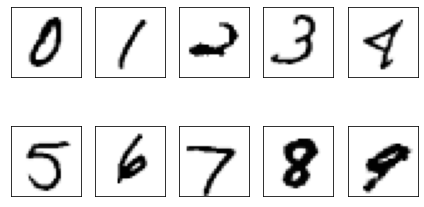

In [8]:
########################
# INITIAL EDA ON NUMBERS
# PICK INDEX AND RENDER
########################

random_idx = 202

# Plot example how each number looks
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train_full[y_train_full == i][random_idx].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

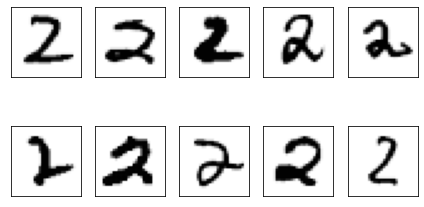

In [9]:
# plot how single number looks
# PICK A NUMBER

random_digit = 2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train_full[y_train_full == random_digit][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
########################
# PREPARE DATA FOR USE
########################

# split data when training -- to ensure by the model
trn_val_splt = int(np.round(X_train_full.shape[0]*0.75,0))

X_train=X_train_full[0:trn_val_splt,:]
y_train=y_train_full[0:trn_val_splt]
X_valid=X_train_full[trn_val_splt:X_train_full.shape[0],:]
y_valid=y_train_full[trn_val_splt:X_train_full.shape[0]]

# data characteristics
n_output = np.unique(y_train).shape[0]  # unique values get the number of class labels
n_features = X_train.shape[1]

# make one-hot of our training, validation, and test y vectors
y_train_enc = fx_make_onehot(y_train, n_output)
print(y_train_enc[y_train_enc[:,9]==1,][0:3,:]) # sanity checks. if index X == 1, the output array shows 1
y_valid_enc = fx_make_onehot(y_valid, n_output)
print(y_valid_enc[y_valid_enc[:,3]==1,][100:103,:]) # sanity checks.  if index X == 1, the output array shows 1
y_test_enc = fx_make_onehot(y_test, n_output)
print(y_test_enc[y_test_enc[:,0]==1,][1000:1003,:]) # sanity checks.  if index X == 1, the output array shows 1

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


<br>

In [11]:
########################
# INITIALIZE VARIABLES
########################

print("Printed shapes of W's and b's")

# model external params
n_hidden = 100
epochs = 100
minibatch_size = 500
l2 = 0.01
eta = 0.01
shuffle = True
randstate_init_w = 823295

# initialize a random state
rand_state = np.random.RandomState(randstate_init_w)

# weights for input -> hidden
# our input data is N x p, so w_h = p x n_h. 
# Thus, 1 x p * p x n_h --> the hidden layer output for ONE data point
b_h = np.zeros(n_hidden)
w_h = rand_state.normal(loc=0.0, scale=0.1, size=(n_features, n_hidden))
print(w_h.shape)
print(b_h.shape)

# weights for hidden -> output
# the "input" is the hidden layer with dim N x n_h, so w_out is n_h x n_out.
# Thus, 1 x n_h * n_h x n_out --> the output layer output for ONE data point
b_out = np.zeros(n_output)
w_out = rand_state.normal(loc=0.0, scale=0.1, size=(n_hidden, n_output))
print(w_out.shape)
print(b_out.shape)

Printed shapes of W's and b's
(784, 100)
(100,)
(100, 10)
(10,)


<br>

In [12]:
########################
# TRAIN OUR NNET MODEL
########################

cost_train_vec = list()
cost_valid_vec = list()
acc_train_vec = list()
acc_valid_vec = list()

time_st = time()

# iterate over training epochs
for i in range(epochs):
    
    # iterate over minibatches
    indices = np.arange(X_train.shape[0])
    
    # randomize the minibatches over each epoch
    if shuffle == True:
        random.shuffle(indices)

    # each epoch, decrease learning rate a little?
    eta_adaptive = eta*(epochs - i) 
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
#     for start_idx in range(0, 1): # USED FOR TEST ONE EXAMPLE ETC
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        X_train_batch = X_train[batch_idx,:]
        
        z_h, a_h, z_out, a_out = fx_forward(X = X_train_batch, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
        w_h, b_h, w_out, b_out = fx_backprop(X_sample = X_train_batch, y_sample = y_train_enc[batch_idx,:], z_h=z_h, 
                                             a_h=a_h, z_out=z_out, a_out=a_out, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out, 
                                             minibatch_size = minibatch_size, l2 = l2, eta = eta_adaptive)
        
    # Use new weights to get performance metrics after every epoch!
    xx_z_h, xx_a_h, xx_z_out, a_trn = fx_forward(X = X_train, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_trn = fx_getpred(a_trn)
    xx_z_h, xx_a_h, xx_z_out, a_val = fx_forward(X = X_valid, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_val = fx_getpred(a_val)
    
    train_cost = np.round(calc_cost_ss(y_pred = a_trn, y = y_train_enc, agg_val = True, take_mean = True), 3)
    valid_cost = np.round(calc_cost_ss(y_pred = a_val, y = y_valid_enc, agg_val = True, take_mean = True), 3)
    train_acc = ((np.sum(y_train == y_pred_trn)).astype(np.float) / X_train.shape[0])
    valid_acc = ((np.sum(y_valid == y_pred_val)).astype(np.float) / X_valid.shape[0])
    
    # Append train/val cost after each epoch
    cost_train_vec.append(train_cost)
    cost_valid_vec.append(valid_cost)
       
    # Append train/val accuracy after each epoch
    acc_train_vec.append(train_acc)
    acc_valid_vec.append(valid_acc)
    
    # write some stats after each epoch
    print(' Epoch {} | Pct Complete : {} | Time Elapsed {} | '.\
          format(str(i), str(np.round(i/epochs, 3)), str(round(time() - time_st, 2))))
    
time_end = time()

print(time_end - time_st)

 Epoch 0 | Pct Complete : 0.0 | Time Elapsed 0.55 | 
 Epoch 1 | Pct Complete : 0.01 | Time Elapsed 1.09 | 
 Epoch 2 | Pct Complete : 0.02 | Time Elapsed 1.61 | 
 Epoch 3 | Pct Complete : 0.03 | Time Elapsed 2.13 | 
 Epoch 4 | Pct Complete : 0.04 | Time Elapsed 2.66 | 
 Epoch 5 | Pct Complete : 0.05 | Time Elapsed 3.21 | 
 Epoch 6 | Pct Complete : 0.06 | Time Elapsed 3.75 | 
 Epoch 7 | Pct Complete : 0.07 | Time Elapsed 4.3 | 
 Epoch 8 | Pct Complete : 0.08 | Time Elapsed 4.84 | 
 Epoch 9 | Pct Complete : 0.09 | Time Elapsed 5.38 | 
 Epoch 10 | Pct Complete : 0.1 | Time Elapsed 5.93 | 
 Epoch 11 | Pct Complete : 0.11 | Time Elapsed 6.48 | 
 Epoch 12 | Pct Complete : 0.12 | Time Elapsed 7.02 | 
 Epoch 13 | Pct Complete : 0.13 | Time Elapsed 7.55 | 
 Epoch 14 | Pct Complete : 0.14 | Time Elapsed 8.08 | 
 Epoch 15 | Pct Complete : 0.15 | Time Elapsed 8.61 | 
 Epoch 16 | Pct Complete : 0.16 | Time Elapsed 9.14 | 
 Epoch 17 | Pct Complete : 0.17 | Time Elapsed 9.69 | 
 Epoch 18 | Pct Complet

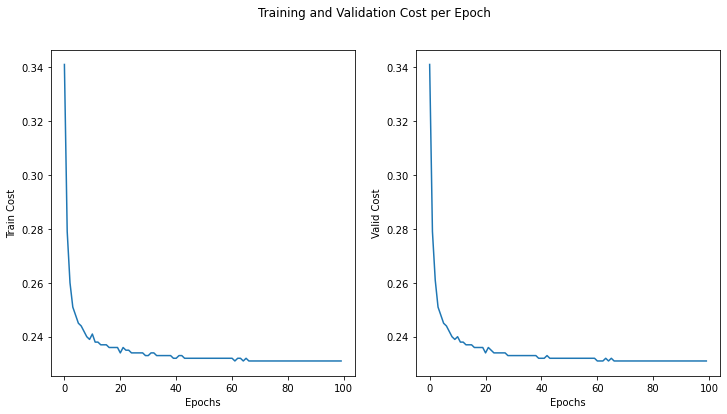

In [13]:
########################
# PLOTTING AVERAGE COST
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training and Validation Cost per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Cost')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Cost')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), cost_train_vec)
ax2.plot(range(epochs), cost_valid_vec)
plt.show()

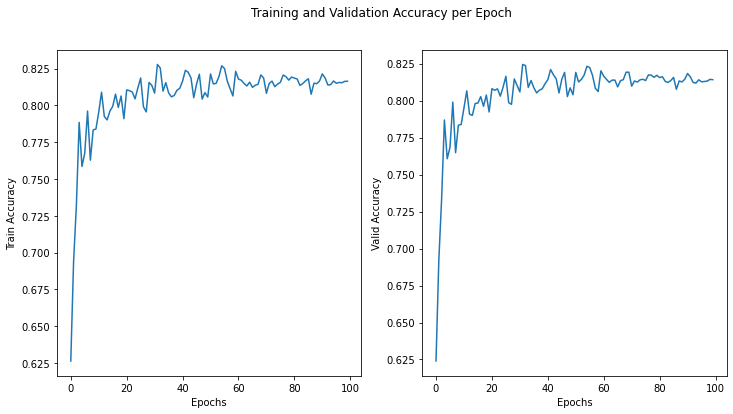

In [14]:
########################
# PLOTTING ACCURACY
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training and Validation Accuracy per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Accuracy')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Accuracy')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), acc_train_vec)
ax2.plot(range(epochs), acc_valid_vec)
plt.show()

<br>

In [16]:
########################
# NNET PERFORMANCE ON TEST
########################

xx_z_h, xx_a_h, xx_z_out, a_test = fx_forward(X = X_test, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
y_pred_test = fx_getpred(a_test)

test_cost = np.round(calc_cost_ss(y_pred = a_test, y = y_test_enc, agg_val = True, take_mean = True), 3)
test_acc = ((np.sum(y_test == y_pred_test)).astype(np.float) / X_test.shape[0])

print('Cost on Training Set: ' + str(np.mean(cost_train_vec[epochs - 10: epochs])))
print('Accuracy on Training Set: ' + str(round(np.mean(acc_train_vec[epochs - 10: epochs]), 3)))
print('')

# no overfittin!
print('Cost on Test Set: ' + str(test_cost))
print('Accuracy on Test Set: ' + str(round(test_acc, 3)))

Cost on Training Set: 0.231
Accuracy on Training Set: 0.816

Cost on Test Set: 0.231
Accuracy on Test Set: 0.813


<br>

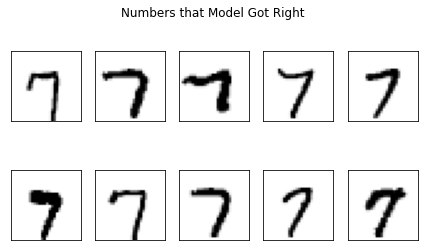

In [17]:
########################
# PERFORMANCE ON SPECIFIC NUMBERS
# PICK A RANDOM NUMBER
########################

rand_digit = 7

# look at numbers we got right
X_right = X_test[(y_test == rand_digit) & (y_pred_test == rand_digit),:]

indices = np.arange(X_right.shape[0])
random.shuffle(indices)

# Plot example how each number looks
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X_right[indices[i]].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
fig.suptitle('Numbers that Model Got Right')
plt.tight_layout()
plt.show()

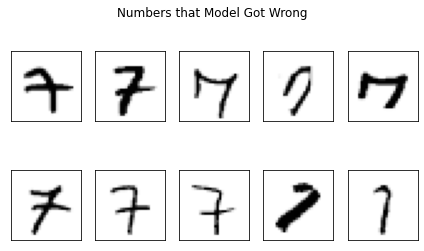

What the Model Predicted:


array([4, 2, 4, 9, 4, 1, 1, 1, 2, 1])

In [18]:
# look at some numbers we got wrong
X_wrong = X_test[(y_test == rand_digit) & (y_pred_test != rand_digit),:]
y_wrong = y_pred_test[(y_test == rand_digit) & (y_pred_test != rand_digit)]

indices = np.arange(X_wrong.shape[0])
random.shuffle(indices)

# Plot example how each number looks
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X_wrong[indices[i]].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
fig.suptitle('Numbers that Model Got Wrong')
plt.tight_layout()
plt.show()

print("What the Model Predicted:")
y_wrong[indices[0:10]]

<br>
<br>

In [19]:
########################
# USE OUR OWN DATASET
# OUR STORY: DATA SCIENTISTS
# ASPIRING STOCK INVESTORS
########################

In [23]:
# yfinance API is super useful
today = dt.datetime.now().strftime('%Y-%m-%d')
snp_hist = yf.download("^GSPC", start="1980-01-01", end= today)
snp_hist['Date'] = snp_hist.index
snp_hist = snp_hist.reset_index(drop = True)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date
10616,4505.750000,4521.859863,4471.470215,4483.870117,4483.870117,3291600000,2022-02-07
10617,4480.020020,4531.319824,4465.399902,4521.540039,4521.540039,3509330000,2022-02-08
10618,4547.000000,4590.029785,4547.000000,4587.180176,4587.180176,3662810000,2022-02-09
10619,4553.240234,4588.919922,4484.310059,4504.080078,4504.080078,4490500000,2022-02-10
10620,4506.270020,4526.330078,4401.410156,4418.640137,4418.640137,4164960000,2022-02-11


In [24]:
snp_hist['return_day'] = snp_hist['Adj Close']/snp_hist['Adj Close'].shift(1) - 1
snp_hist['return_week'] = snp_hist['Adj Close']/snp_hist['Adj Close'].shift(5) - 1
snp_hist['return_month'] = snp_hist['Adj Close']/snp_hist['Adj Close'].shift(20) - 1
snp_hist['voldiff_day'] = snp_hist['Volume']/snp_hist['Volume'].shift(1) - 1

<br>

In [22]:
########################
# EXPLORE THE SNP DATASET
########################

snp_hist.tail()

,Open,High,Low,Close,Adj Close,Volume,Date,return_day,return_week,return_month,voldiff_day
10605,4471.379883,4494.520020,4395.339844,4397.939941,4397.939941,3945810000,2022-01-21,-0.018915,-0.056040,-0.063583,0.136119
10606,4356.319824,4417.350098,4222.620117,4410.129883,4410.129883,5172540000,2022-01-24,0.002772,-0.054199,-0.066795,0.310894
10607,4366.640137,4411.009766,4287.109863,4356.450195,4356.450195,3989420000,2022-01-25,-0.012172,-0.048209,-0.090737,-0.228731
10608,4408.430176,4453.229980,4304.799805,4349.930176,4349.930176,4046270000,2022-01-26,-0.001497,-0.040335,-0.091180,0.014250
10609,4336.189941,4432.720215,4292.459961,4431.850098,4431.850098,2913164000,2022-01-28,0.018832,-0.011350,-0.075361,-0.280037


In [23]:
snp_hist.head()

,Open,High,Low,Close,Adj Close,Volume,Date,return_day,return_week,return_month,voldiff_day
0,0.0,108.430000,105.290001,105.760002,105.760002,40610000,1980-01-02,NaN,NaN,NaN,NaN
1,0.0,106.080002,103.260002,105.220001,105.220001,50480000,1980-01-03,-0.005106,NaN,NaN,0.243044
2,0.0,107.080002,105.089996,106.519997,106.519997,39130000,1980-01-04,0.012355,NaN,NaN,-0.224842
3,0.0,107.800003,105.800003,106.809998,106.809998,44500000,1980-01-07,0.002723,NaN,NaN,0.137235
4,0.0,109.290001,106.290001,108.949997,108.949997,53390000,1980-01-08,0.020036,NaN,NaN,0.199775


In [24]:
print(snp_hist.shape)
print('')
print('Years of Data: ' + str(np.round(snp_hist.shape[0]/250, 3)))

(10610, 11)

Years of Data: 42.44


In [25]:
########################
# DAY OVER DAY RETURNS
########################

pd.concat((snp_hist.loc[0:9300, 'return_day'].describe(percentiles = [elem / 20 for elem in list(range(1, 20))]).to_frame(), 
           snp_hist.loc[9300:len(snp_hist), 'return_day'].describe(percentiles = [elem / 20 for elem in list(range(1, 20))]).to_frame()),
          axis = 1, keys = ['daily_returns_pre_2017', 'daily_returns_last_5yr'])

,daily_returns_pre_2017,daily_returns_last_5yr
,return_day,return_day
count,9300.000000,1310.000000
mean,0.000387,0.000619
std,0.011144,0.011972
min,-0.204669,-0.119841
5%,-0.016498,-0.017402
10%,-0.011276,-0.009211
15%,-0.008374,-0.006633
20%,-0.006386,-0.004472
25%,-0.004665,-0.002962


<br>

In [26]:
########################
# CREATE DATASET FEATURES
########################

# Create Features using Stock Price Returns
feat_names = ['return_lag_'+ str(elem) for elem in list(range(1, 21))]
feat_names.append('return_week_lag_1w')
feat_names.append('return_week_lag_2w')
feat_names.append('return_week_lag_3w')
feat_names.append('return_week_lag_4w')

df_features = pd.DataFrame()

for day_lag in range(1, 21):
    col_lag = snp_hist['return_day'].shift(day_lag)
    df_features = pd.concat([df_features, col_lag], axis = 1, ignore_index = True)

col_lag_1w = snp_hist['return_week'].shift(5)
col_lag_2w = snp_hist['return_week'].shift(10)
col_lag_3w = snp_hist['return_week'].shift(15)
col_lag_4w = snp_hist['return_week'].shift(20)
df_features = pd.concat([df_features, col_lag_1w, col_lag_2w, col_lag_3w, col_lag_4w], axis = 1, ignore_index = True)

df_features.columns = feat_names

In [27]:
# Create Features using Volumes Diffs DoD 
feat_names = ['voldiff_lag'+ str(elem) for elem in list(range(1, 16))]
# feat_names.append('voldiff_lag_15')
feat_names.append('voldiff_lag_20')

df_vols = pd.DataFrame()

for day_lag in range(1, 16):
    col_lag = snp_hist['voldiff_day'].shift(day_lag)/10 # scale volume diff by 1/10 so within range of price returns?
    df_vols = pd.concat([df_vols, col_lag], axis = 1, ignore_index = True)

# col_lag = snp_hist['voldiff_day'].shift(15)
# df_vols = pd.concat([df_vols, col_lag], axis = 1, ignore_index = True)
col_lag = snp_hist['voldiff_day'].shift(20)/10 # scale volume diff by 1/10 so within range of price returns?
df_vols = pd.concat([df_vols, col_lag], axis = 1, ignore_index = True)

df_vols.columns = feat_names

<br>

In [30]:
########################
# CREATE DATASET TARGET
########################

# First, let's look at daily returns > 1%
snp_final = pd.concat([snp_hist, df_features, df_vols], axis = 1)
snp_final = snp_final.iloc[25:,:] # otherwise the return_week_lag_4w is nan
snp_final['target'] = (snp_final['return_day'] > 0.01)*1
snp_final = snp_final.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date', \
                                      'return_day', 'return_week', 'return_month', 'voldiff_day'])

In [31]:
print('Baseline Success Rate: ' + str(round(np.mean(snp_final['target']), 3)))

Baseline Success Rate: 0.132


In [29]:
snp_final.columns

Index(['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4',
       'return_lag_5', 'return_lag_6', 'return_lag_7', 'return_lag_8',
       'return_lag_9', 'return_lag_10', 'return_lag_11', 'return_lag_12',
       'return_lag_13', 'return_lag_14', 'return_lag_15', 'return_lag_16',
       'return_lag_17', 'return_lag_18', 'return_lag_19', 'return_lag_20',
       'return_week_lag_1w', 'return_week_lag_2w', 'return_week_lag_3w',
       'return_week_lag_4w', 'voldiff_lag1', 'voldiff_lag2', 'voldiff_lag3',
       'voldiff_lag4', 'voldiff_lag5', 'voldiff_lag6', 'voldiff_lag7',
       'voldiff_lag8', 'voldiff_lag9', 'voldiff_lag10', 'voldiff_lag11',
       'voldiff_lag12', 'voldiff_lag13', 'voldiff_lag14', 'voldiff_lag15',
       'voldiff_lag_20', 'target'],
      dtype='object')

<br>

In [32]:
########################
# PREPARE DATA FOR USE
########################

X = snp_final.drop(columns = 'target')
y = snp_final['target']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train_full.shape)

trn_val_splt = int(np.round(X_train_full.shape[0]*0.75,0))

# split data when training
X_train=X_train_full.iloc[:trn_val_splt,:].to_numpy()
y_train=y_train_full.iloc[:trn_val_splt].to_numpy()
X_valid=X_train_full.iloc[trn_val_splt:,:].to_numpy()
y_valid=y_train_full.iloc[trn_val_splt:].to_numpy()

# data characteristics
n_output = np.unique(y_train).shape[0]  # unique values get the number of class labels
n_features = X_train.shape[1]

# make one-hot of our training, validation, and test y vectors
y_train_enc = fx_make_onehot(y_train, n_output)
print(y_train_enc[y_train_enc[:,0]==1,][0:3,:]) # sanity checks
y_valid_enc = fx_make_onehot(y_valid, n_output)
print(y_valid_enc[y_valid_enc[:,1]==1,][0:3,:]) # sanity checks
y_test_enc = fx_make_onehot(y_test, n_output)

(7409, 40)
[[1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]]


<br>

In [34]:
########################
# INITIALIZE VARIABLES
########################

print("Printed shapes of W's and b's")

# model external params
n_hidden = 30
epochs = 100
minibatch_size = 250
l2 = 0.1
eta = 0.005
shuffle = True
randstate_init_w = 498593

# initialize a random state
rand_state = np.random.RandomState(randstate_init_w)

# weights for input -> hidden
# our input data is N x p, so w_h = p x n_h. 
# Thus, 1 x p * p x n_h --> the hidden layer output for ONE data point
b_h = np.zeros(n_hidden)
w_h = rand_state.normal(loc=0.0, scale=0.1, size=(n_features, n_hidden))
print(w_h.shape)
print(b_h.shape)

# weights for hidden -> output
# the "input" is the hidden layer with dim N x n_h, so w_out is n_h x n_out.
# Thus, 1 x n_h * n_h x n_out --> the output layer output for ONE data point
b_out = np.zeros(n_output)
w_out = rand_state.normal(loc=0.0, scale=0.1, size=(n_hidden, n_output))
print(b_out.shape)
print(w_out.shape)

Printed shapes of W's and b's
(40, 30)
(30,)
(2,)
(30, 2)


<br>

In [35]:
########################
# TRAIN OUR NNET MODEL
########################

# save results in lists
cost_train_vec = list()
cost_valid_vec = list()
acc_train_vec = list()
acc_valid_vec = list()
prec_train_vec = list()
prec_valid_vec = list()

time_st = time()

# iterate over training epochs
for i in range(epochs):
    
    # iterate over minibatches
    indices = np.arange(X_train.shape[0])
    
    # randomize the minibatches over each epoch
    if shuffle == True:
        random.shuffle(indices)

    # each epoch, decrease learning rate a little?
    eta_adaptive = eta*(epochs - i) 
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
#     for start_idx in range(0, 1): # USED FOR TEST ONE EXAMPLE ETC
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        X_train_batch = X_train[batch_idx,:]
        
        z_h, a_h, z_out, a_out = fx_forward(X = X_train_batch, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
        w_h, b_h, w_out, b_out = fx_backprop(X_sample = X_train_batch, y_sample = y_train_enc[batch_idx,:], z_h=z_h, 
                                             a_h=a_h, z_out=z_out, a_out=a_out, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out, 
                                             minibatch_size = minibatch_size, l2 = l2, eta = eta_adaptive)
    
    # Use new weights to get performance metrics after every epoch!
    xx_z_h, xx_a_h, xx_z_out, a_trn = fx_forward(X = X_train, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_trn = fx_getpred(a_trn)
    xx_z_h, xx_a_h, xx_z_out, a_val = fx_forward(X = X_valid, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_val = fx_getpred(a_val)
    
    train_cost = calc_cost_ss(y_pred = a_trn, y = y_train_enc, agg_val = True, take_mean = True)
    valid_cost = calc_cost_ss(y_pred = a_val, y = y_valid_enc, agg_val = True, take_mean = True)
    train_acc = ((np.sum(y_train == y_pred_trn)).astype(np.float) / X_train.shape[0])
    valid_acc = ((np.sum(y_valid == y_pred_val)).astype(np.float) / X_valid.shape[0])
    train_prec = precis_top_x(a_vec = a_trn, y_enc = y_train_enc, col_idx=1, top_x=500)
    valid_prec = precis_top_x(a_vec = a_val, y_enc = y_valid_enc, col_idx=1, top_x=500)
    
    # Append train/val cost after each epoch
    cost_train_vec.append(train_cost)
    cost_valid_vec.append(valid_cost)
       
    # Append train/val accuracy after each epoch
    acc_train_vec.append(train_acc)
    acc_valid_vec.append(valid_acc)
    
    # Append train/val precision metric after each epoch
    prec_train_vec.append(train_prec)
    prec_valid_vec.append(valid_prec)
    
    # write some stats after each epoch
    print(' Epoch {} | Pct Complete : {} | Time Elapsed {} | '.\
          format(str(i), str(np.round(i/epochs, 3)), str(round(time() - time_st, 2))))
    
time_end = time()

print(time_end - time_st)

 Epoch 0 | Pct Complete : 0.0 | Time Elapsed 0.03 | 
 Epoch 1 | Pct Complete : 0.01 | Time Elapsed 0.05 | 
 Epoch 2 | Pct Complete : 0.02 | Time Elapsed 0.08 | 
 Epoch 3 | Pct Complete : 0.03 | Time Elapsed 0.11 | 
 Epoch 4 | Pct Complete : 0.04 | Time Elapsed 0.13 | 
 Epoch 5 | Pct Complete : 0.05 | Time Elapsed 0.16 | 
 Epoch 6 | Pct Complete : 0.06 | Time Elapsed 0.18 | 
 Epoch 7 | Pct Complete : 0.07 | Time Elapsed 0.21 | 
 Epoch 8 | Pct Complete : 0.08 | Time Elapsed 0.25 | 
 Epoch 9 | Pct Complete : 0.09 | Time Elapsed 0.27 | 
 Epoch 10 | Pct Complete : 0.1 | Time Elapsed 0.3 | 
 Epoch 11 | Pct Complete : 0.11 | Time Elapsed 0.32 | 
 Epoch 12 | Pct Complete : 0.12 | Time Elapsed 0.35 | 
 Epoch 13 | Pct Complete : 0.13 | Time Elapsed 0.38 | 
 Epoch 14 | Pct Complete : 0.14 | Time Elapsed 0.41 | 
 Epoch 15 | Pct Complete : 0.15 | Time Elapsed 0.44 | 
 Epoch 16 | Pct Complete : 0.16 | Time Elapsed 0.47 | 
 Epoch 17 | Pct Complete : 0.17 | Time Elapsed 0.49 | 
 Epoch 18 | Pct Complet

<br>

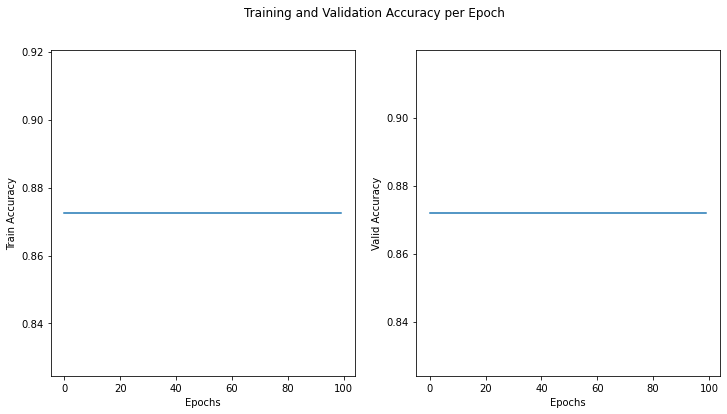

In [36]:
########################
# PLOTTING ACCURACY
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training and Validation Accuracy per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Accuracy')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Accuracy')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), acc_train_vec)
ax2.plot(range(epochs), acc_valid_vec)
plt.show()

In [37]:
# print(np.quantile(a_trn[:,1], [0, 0.25, 0.5, 0.75, 1]))
print(np.quantile(a_val[:,1], [0, 0.25, 0.5, 0.75, 1]))
# print(round(np.mean(y_train_enc[:,0]), 3))
print(round(np.mean(y_valid_enc[:,0]), 3))

[0.12981838 0.12981838 0.12981838 0.12981838 0.12981839]
0.872


<br>

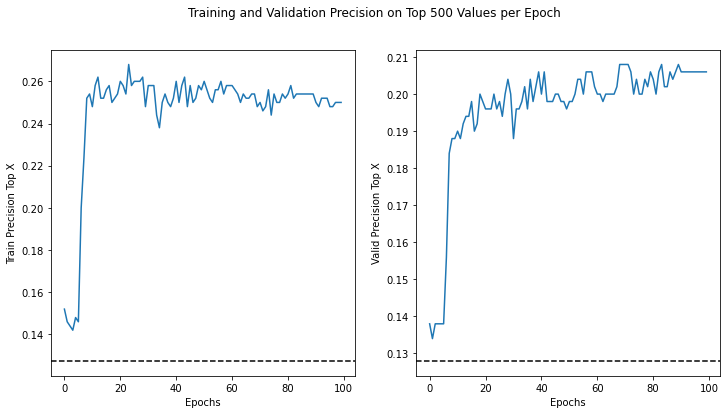

In [38]:
########################
# PLOTTING PRECISION TOP X
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training and Validation Precision on Top 500 Values per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Precision Top X')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Precision Top X')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), prec_train_vec)
ax1.axhline(y=np.mean(y_train), color='black', linestyle='--')
ax2.plot(range(epochs), prec_valid_vec)
ax2.axhline(y=np.mean(y_valid), color='black', linestyle='--')
plt.show()

In [ ]:
# Cost function values
print(cost_train_vec[epochs-1])
print(cost_valid_vec[epochs-1])

<br>

In [39]:
########################
# NNET PERFORMANCE ON TEST DATASET
########################

top5_pct = int(round(X_test.shape[0]/20,0))
top10_pct = int(round(X_test.shape[0]/10,0))
top25_pct = int(round(X_test.shape[0]/4,0))
top50_pct = int(round(X_test.shape[0]/2,0))

xx_z_h, xx_a_h, xx_z_out, a_test = fx_forward(X = X_test, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)

print('Precisions Top 100, 250, 500: ')
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=100))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=250))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=500))
print('')
print('Precisions Top 5%, 10%, 25%, 50%: ')
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top5_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top10_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top25_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top50_pct), 3))
print('')
print('Guessing: ' + str(round(np.mean(y_test),3)))

Precisions Top 100, 250, 500: 
0.33
0.276
0.24

Precisions Top 5%, 10%, 25%, 50%: 
0.308
0.274
0.21
0.168

Guessing: 0.142


<br>

In [40]:
########################
# BUILD A DEEPER NNET
########################

In [41]:
########################
# RE-INITIALIZE VARIABLES
########################

print("Printed shapes of W's and b's")

# model external params
n_hidden2 = 30 # arbitrary Adam decides :-)
n_hidden = 10 # arbitrary Adam decides :-)
epochs = 100
minibatch_size = 250
l2 = 0.1
eta = 0.005 # #0.005, 0.0025, 0.001
shuffle = True
randstate_init_w = 560738

# initialize a random state
rand_state = np.random.RandomState(randstate_init_w)

# weights for input -> hidden2
# our input data is N x p, so w_h = p x n_h. 
# Thus, 1 x p * p x n_h --> the hidden layer output for ONE data point
b_h2 = np.zeros(n_hidden2)
w_h2 = rand_state.normal(loc=0.0, scale=0.1, size=(n_features, n_hidden2))
print(w_h2.shape)
print(b_h2.shape)

# weights for hidden2 -> hidden
# our input data is N x p, so w_h = p x n_h. 
# Thus, 1 x p * p x n_h --> the hidden layer output for ONE data point
b_h = np.zeros(n_hidden)
w_h = rand_state.normal(loc=0.0, scale=0.1, size=(n_hidden2, n_hidden))
print(w_h.shape)
print(b_h.shape)

# weights for hidden -> output
# the "input" is the hidden layer with dim N x n_h, so w_out is n_h x n_out.
# Thus, 1 x n_h * n_h x n_out --> the output layer output for ONE data point
b_out = np.zeros(n_output)
w_out = rand_state.normal(loc=0.0, scale=0.1, size=(n_hidden, n_output))
print(w_out.shape)
print(b_out.shape)

Printed shapes of W's and b's
(40, 30)
(30,)
(30, 10)
(10,)
(10, 2)
(2,)


<br>

In [42]:
########################
# TRAIN NNET W/ 4 LAYER
########################

# save results in lists
cost_train_vec = list()
cost_valid_vec = list()
acc_train_vec = list()
acc_valid_vec = list()
prec_train_vec = list()
prec_valid_vec = list()

time_st = time()

# iterate over training epochs
for i in range(epochs):
    
    # iterate over minibatches
    indices = np.arange(X_train.shape[0])
    
    # randomize the minibatches over each epoch
    if shuffle == True:
        random.shuffle(indices)

    # each epoch, decrease learning rate a little?
    eta_adaptive = eta*(epochs - i) 
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        X_train_batch = X_train[batch_idx,:]
        
        z_h2, a_h2, z_h, a_h, z_out, a_out = fx_forward_2(X = X_train_batch, w_h2=w_h2, b_h2=b_h2, 
                                                          w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
        w_h2, b_h2, w_h, b_h, w_out, b_out = fx_backprop_2(X_sample = X_train_batch, y_sample = y_train_enc[batch_idx,:], 
                                                           z_h2=z_h2, a_h2=a_h2, z_h=z_h, a_h=a_h, z_out=z_out, a_out=a_out, 
                                                           w_h2=w_h2, b_h2=b_h2, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out, 
                                                           minibatch_size = minibatch_size, l2 = l2, eta = eta_adaptive)
    
    # Use new weights to get performance metrics after every epoch!
    xx_z_h2, xx_a_h2, xx_z_h, xx_a_h, xx_z_out, a_trn = fx_forward_2(X = X_train, w_h2=w_h2, b_h2=b_h2, 
                                                                     w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_trn = fx_getpred(a_trn)
    xx_z_h2, xx_a_h2, xx_z_h, xx_a_h, xx_z_out, a_val = fx_forward_2(X = X_valid, w_h2=w_h2, b_h2=b_h2, 
                                                                     w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_val = fx_getpred(a_val)
    
    train_cost = calc_cost_ss(y_pred = a_trn, y = y_train_enc, agg_val = True, take_mean = True)
    valid_cost = calc_cost_ss(y_pred = a_val, y = y_valid_enc, agg_val = True, take_mean = True)
    train_acc = ((np.sum(y_train == y_pred_trn)).astype(np.float) / X_train.shape[0])
    valid_acc = ((np.sum(y_valid == y_pred_val)).astype(np.float) / X_valid.shape[0])
    train_prec = precis_top_x(a_vec = a_trn, y_enc = y_train_enc, col_idx=1, top_x=500)
    valid_prec = precis_top_x(a_vec = a_val, y_enc = y_valid_enc, col_idx=1, top_x=500)
    
    # Append train/val cost after each epoch
    cost_train_vec.append(train_cost)
    cost_valid_vec.append(valid_cost)
       
    # Append train/val accuracy after each epoch
    acc_train_vec.append(train_acc)
    acc_valid_vec.append(valid_acc)
    
    # Append train/val precision metric after each epoch
    prec_train_vec.append(train_prec)
    prec_valid_vec.append(valid_prec)
    
    # write some stats after each epoch
    print(' Epoch {} | Pct Complete : {} | Time Elapsed {} | '.\
          format(str(i), str(np.round(i/epochs, 3)), str(round(time() - time_st, 2))))
    
time_end = time()

print(time_end - time_st)

 Epoch 0 | Pct Complete : 0.0 | Time Elapsed 0.03 | 
 Epoch 1 | Pct Complete : 0.01 | Time Elapsed 0.07 | 
 Epoch 2 | Pct Complete : 0.02 | Time Elapsed 0.1 | 
 Epoch 3 | Pct Complete : 0.03 | Time Elapsed 0.13 | 
 Epoch 4 | Pct Complete : 0.04 | Time Elapsed 0.16 | 
 Epoch 5 | Pct Complete : 0.05 | Time Elapsed 0.19 | 
 Epoch 6 | Pct Complete : 0.06 | Time Elapsed 0.23 | 
 Epoch 7 | Pct Complete : 0.07 | Time Elapsed 0.26 | 
 Epoch 8 | Pct Complete : 0.08 | Time Elapsed 0.29 | 
 Epoch 9 | Pct Complete : 0.09 | Time Elapsed 0.32 | 
 Epoch 10 | Pct Complete : 0.1 | Time Elapsed 0.36 | 
 Epoch 11 | Pct Complete : 0.11 | Time Elapsed 0.39 | 
 Epoch 12 | Pct Complete : 0.12 | Time Elapsed 0.42 | 
 Epoch 13 | Pct Complete : 0.13 | Time Elapsed 0.45 | 
 Epoch 14 | Pct Complete : 0.14 | Time Elapsed 0.48 | 
 Epoch 15 | Pct Complete : 0.15 | Time Elapsed 0.51 | 
 Epoch 16 | Pct Complete : 0.16 | Time Elapsed 0.55 | 
 Epoch 17 | Pct Complete : 0.17 | Time Elapsed 0.58 | 
 Epoch 18 | Pct Complet

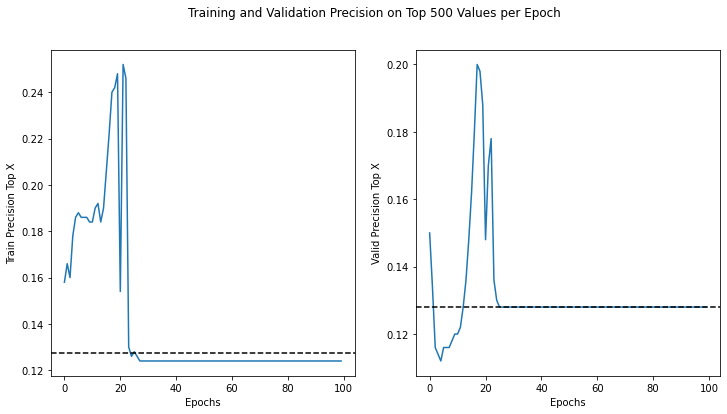

In [43]:
########################
# PLOTTING PRECISION
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training and Validation Precision on Top 500 Values per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Precision Top X')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Precision Top X')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), prec_train_vec)
ax1.axhline(y=np.mean(y_train), color='black', linestyle='--')
ax2.plot(range(epochs), prec_valid_vec)
ax2.axhline(y=np.mean(y_valid), color='black', linestyle='--')
plt.show()

<br>

In [44]:
########################
# NNET PERFORMANCE ON TEST
########################

top5_pct = int(round(X_test.shape[0]/20,0))
top10_pct = int(round(X_test.shape[0]/10,0))
top25_pct = int(round(X_test.shape[0]/4,0))
top50_pct = int(round(X_test.shape[0]/2,0))

xx_z_h2, xx_a_h2, xx_z_h, xx_a_h, xx_z_out, a_test = fx_forward_2(X = X_test, w_h2=w_h2, b_h2=b_h2, 
                                                                  w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)

print('Precisions Top 100, 250, 500: ')
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=100))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=250))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=500))
print('')
print('Precisions Top 5%, 10%, 25%, 50%: ')
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top5_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top10_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top25_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top50_pct), 3))
print('')
print('Guessing: ' + str(round(np.mean(y_test),3)))

Precisions Top 100, 250, 500: 
0.14
0.136
0.13

Precisions Top 5%, 10%, 25%, 50%: 
0.119
0.129
0.125
0.144

Guessing: 0.142


<br>
<b>Deeper networks are NOT automatically better!</b>

<br>

In [45]:
########################
# EXLORE WEEKLY RETURNS
########################

pd.concat((snp_hist.loc[0:9300, 'return_week'].describe(percentiles = [elem / 20 for elem in list(range(1, 20))]).to_frame(), 
           snp_hist.loc[9300:10610, 'return_week'].describe(percentiles = [elem / 20 for elem in list(range(1, 20))]).to_frame()),
          axis = 1, keys = ['weekly_returns_pre_2017', 'weekly_returns_last_5yr'])

,weekly_returns_pre_2017,weekly_returns_last_5yr
,return_week,return_week
count,9296.000000,1310.000000
mean,0.001898,0.003005
std,0.023486,0.023599
min,-0.273280,-0.179666
5%,-0.035219,-0.034603
10%,-0.024961,-0.020405
15%,-0.018589,-0.013022
20%,-0.014408,-0.008824
25%,-0.010485,-0.005016


In [46]:
#######################
# RECREATE DATASET TARGET
########################

# Establish 2 class with >1% weekly return?
snp_final = pd.concat([snp_hist, df_features, df_vols], axis = 1)
snp_final = snp_final.iloc[25:,:] # otherwise the return_week_lag_4w is nan
snp_final['target'] = (snp_final['return_week'] > 0.01)*1
snp_final = snp_final.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date', \
                                      'return_day', 'return_week', 'return_month', 'voldiff_day', \
                                      # get rid of the recent 5 day returns, since WEEKLY
                                     'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5'])

In [47]:
print('Baseline Success Rate: ' + str(round(np.mean(snp_final['target']), 3)))

Baseline Success Rate: 0.347


In [48]:
print(snp_final.columns)

Index(['return_lag_6', 'return_lag_7', 'return_lag_8', 'return_lag_9',
       'return_lag_10', 'return_lag_11', 'return_lag_12', 'return_lag_13',
       'return_lag_14', 'return_lag_15', 'return_lag_16', 'return_lag_17',
       'return_lag_18', 'return_lag_19', 'return_lag_20', 'return_week_lag_1w',
       'return_week_lag_2w', 'return_week_lag_3w', 'return_week_lag_4w',
       'voldiff_lag1', 'voldiff_lag2', 'voldiff_lag3', 'voldiff_lag4',
       'voldiff_lag5', 'voldiff_lag6', 'voldiff_lag7', 'voldiff_lag8',
       'voldiff_lag9', 'voldiff_lag10', 'voldiff_lag11', 'voldiff_lag12',
       'voldiff_lag13', 'voldiff_lag14', 'voldiff_lag15', 'voldiff_lag_20',
       'target'],
      dtype='object')


<br>

In [50]:
########################
# PREPARE DATA FOR USE
# THIS TIME CHRONOLOGICALLY
########################

X = snp_final.drop(columns = 'target')
y = snp_final['target']

total_obs = snp_final.shape[0]
train_idx = total_obs - 2500 # from 10 years to 5 years
valid_idx = total_obs - 1250 # from 5 years to now

X_train = X.iloc[0:train_idx,:].to_numpy()
y_train = y.iloc[0:train_idx].to_numpy()
X_valid = X.iloc[train_idx:valid_idx,:].to_numpy()
y_valid = y.iloc[train_idx:valid_idx].to_numpy()
X_test = X.iloc[valid_idx:total_obs,:].to_numpy()
y_test = y.iloc[valid_idx:total_obs].to_numpy()

# data characteristics
n_output = np.unique(y_train).shape[0]  # unique values get the number of class labels
n_features = X_train.shape[1]

# make one-hot of our training, validation, and test y vectors
y_train_enc = fx_make_onehot(y_train, n_output)
y_valid_enc = fx_make_onehot(y_valid, n_output)
y_test_enc = fx_make_onehot(y_test, n_output)

<br>

In [52]:
########################
# INITIALIZE VARIABLES
########################

print("Printed shapes of W's and b's")

# model external params
n_hidden = 25
epochs = 100
minibatch_size = 250
l2 = 0.1
eta = 0.001
shuffle = True
randstate_init_w = 825731

# initialize a random state
rand_state = np.random.RandomState(randstate_init_w)

# weights for input -> hidden
# our input data is N x p, so w_h = p x n_h. 
# Thus, 1 x p * p x n_h --> the hidden layer output for ONE data point
b_h = np.zeros(n_hidden)
w_h = rand_state.normal(loc=0.0, scale=0.1, size=(n_features, n_hidden))
print(w_h.shape)
print(b_h.shape)

# weights for hidden -> output
# the "input" is the hidden layer with dim N x n_h, so w_out is n_h x n_out.
# Thus, 1 x n_h * n_h x n_out --> the output layer output for ONE data point
b_out = np.zeros(n_output)
w_out = rand_state.normal(loc=0.0, scale=0.1, size=(n_hidden, n_output))
print(w_out.shape)
print(b_out.shape)

Printed shapes of W's and b's
(35, 25)
(25,)
(25, 2)
(2,)


<br>

In [53]:
########################
# TRAIN NNET ON NEW TARGET
########################

# save results in lists
cost_train_vec = list()
cost_valid_vec = list()
acc_train_vec = list()
acc_valid_vec = list()
prec_train_vec = list()
prec_valid_vec = list()

time_st = time()

# iterate over training epochs
for i in range(epochs):
    
    # iterate over minibatches
    indices = np.arange(X_train.shape[0])
    
    # randomize the minibatches over each epoch
    if shuffle == True:
        random.shuffle(indices)

    # each epoch, decrease learning rate linearly?
    eta_adaptive = eta*(epochs - i)
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
#     for start_idx in range(0, 1): # USED FOR TEST ONE EXAMPLE ETC
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        X_train_batch = X_train[batch_idx,:]
        
        z_h, a_h, z_out, a_out = fx_forward(X = X_train_batch, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
        w_h, b_h, w_out, b_out = fx_backprop(X_sample = X_train_batch, y_sample = y_train_enc[batch_idx,:], z_h=z_h, 
                                             a_h=a_h, z_out=z_out, a_out=a_out, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out, 
                                             minibatch_size = minibatch_size, l2 = l2, eta = eta_adaptive)
    
    # Use new weights to get performance metrics after every epoch!
    xx_z_h, xx_a_h, xx_z_out, a_trn = fx_forward(X = X_train, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_trn = fx_getpred(a_trn)
    xx_z_h, xx_a_h, xx_z_out, a_val = fx_forward(X = X_valid, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)
    y_pred_val = fx_getpred(a_val)
    
    train_cost = calc_cost_ss(y_pred = a_trn, y = y_train_enc, agg_val = True, take_mean = True)
    valid_cost = calc_cost_ss(y_pred = a_val, y = y_valid_enc, agg_val = True, take_mean = True)
    train_acc = ((np.sum(y_train == y_pred_trn)).astype(np.float) / X_train.shape[0])
    valid_acc = ((np.sum(y_valid == y_pred_val)).astype(np.float) / X_valid.shape[0])
    train_prec = precis_top_x(a_vec = a_trn, y_enc = y_train_enc, col_idx=1, top_x=500)
    valid_prec = precis_top_x(a_vec = a_val, y_enc = y_valid_enc, col_idx=1, top_x=250)
    
    # Append train/val cost after each epoch
    cost_train_vec.append(train_cost)
    cost_valid_vec.append(valid_cost)
       
    # Append train/val accuracy after each epoch
    acc_train_vec.append(train_acc)
    acc_valid_vec.append(valid_acc)
    
    # Append train/val precision metric after each epoch
    prec_train_vec.append(train_prec)
    prec_valid_vec.append(valid_prec)
    
    # write some stats after each epoch
    print(' Epoch {} | Pct Complete : {} | Time Elapsed {} | '.\
          format(str(i), str(np.round(i/epochs, 3)), str(round(time() - time_st, 2))))
    
time_end = time()

print(time_end - time_st)

 Epoch 0 | Pct Complete : 0.0 | Time Elapsed 0.03 | 
 Epoch 1 | Pct Complete : 0.01 | Time Elapsed 0.06 | 
 Epoch 2 | Pct Complete : 0.02 | Time Elapsed 0.09 | 
 Epoch 3 | Pct Complete : 0.03 | Time Elapsed 0.13 | 
 Epoch 4 | Pct Complete : 0.04 | Time Elapsed 0.16 | 
 Epoch 5 | Pct Complete : 0.05 | Time Elapsed 0.19 | 
 Epoch 6 | Pct Complete : 0.06 | Time Elapsed 0.22 | 
 Epoch 7 | Pct Complete : 0.07 | Time Elapsed 0.25 | 
 Epoch 8 | Pct Complete : 0.08 | Time Elapsed 0.28 | 
 Epoch 9 | Pct Complete : 0.09 | Time Elapsed 0.31 | 
 Epoch 10 | Pct Complete : 0.1 | Time Elapsed 0.34 | 
 Epoch 11 | Pct Complete : 0.11 | Time Elapsed 0.37 | 
 Epoch 12 | Pct Complete : 0.12 | Time Elapsed 0.4 | 
 Epoch 13 | Pct Complete : 0.13 | Time Elapsed 0.43 | 
 Epoch 14 | Pct Complete : 0.14 | Time Elapsed 0.46 | 
 Epoch 15 | Pct Complete : 0.15 | Time Elapsed 0.49 | 
 Epoch 16 | Pct Complete : 0.16 | Time Elapsed 0.52 | 
 Epoch 17 | Pct Complete : 0.17 | Time Elapsed 0.55 | 
 Epoch 18 | Pct Complet

<br>

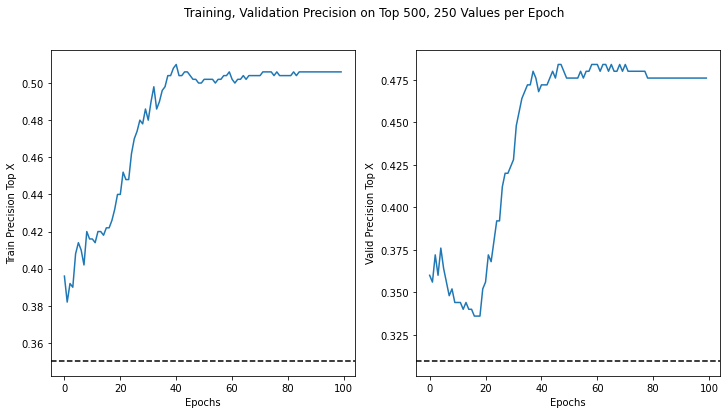

In [54]:
########################
# PLOTTING PRECISION
########################

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training, Validation Precision on Top 500, 250 Values per Epoch')
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Train Precision Top X')
ax1.set_xlabel('Epochs')
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Valid Precision Top X')
ax2.set_xlabel('Epochs')

ax1.plot(range(epochs), prec_train_vec)
ax1.axhline(y=np.mean(y_train), color='black', linestyle='--')
ax2.plot(range(epochs), prec_valid_vec)
ax2.axhline(y=np.mean(y_valid), color='black', linestyle='--')
plt.show()

<br>

In [55]:
########################
# NNET PERFORMANCE ON TEST
########################

top5_pct = int(round(X_test.shape[0]/20,0))
top10_pct = int(round(X_test.shape[0]/10,0))
top25_pct = int(round(X_test.shape[0]/4,0))
top50_pct = int(round(X_test.shape[0]/2,0))

xx_z_h, xx_a_h, xx_z_out, a_test = fx_forward(X = X_test, w_h=w_h, b_h=b_h, w_out=w_out, b_out=b_out)

print('Precisions Top 100, 250, 500: ')
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=100))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=250))
print(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=500))
print('')
print('Precisions Top 5%, 10%, 25%, 50%: ')
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top5_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top10_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top25_pct), 3))
print(round(precis_top_x(a_vec = a_test, y_enc = y_test_enc, col_idx=1, top_x=top50_pct), 3))
print('')
print('Guessing: ' + str(round(np.mean(y_test),3)))

Precisions Top 100, 250, 500: 
0.51
0.468
0.418

Precisions Top 5%, 10%, 25%, 50%: 
0.5
0.496
0.471
0.389

Guessing: 0.362


<br>

In [58]:
########################
# SOME LIGHT BACKTESTING
########################

snp_testing = pd.concat([snp_hist, df_features, df_vols], axis = 1)
snp_testing = snp_testing.iloc[25:,:] # otherwise the return_week_lag_4w is nan
snp_testing['target'] = (snp_testing['return_week'] > 0.01)*1
snp_testing = snp_testing.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Date', 'return_week', 'target']]

snp_testing = snp_testing.iloc[valid_idx:total_obs,:].reset_index(drop = True)

# pick the top 250 days where we hit (i.e. around 20% of the days)
top250_idx = np.argpartition(a_test[:,1], -250)[-250:]
top250_indices = top250_idx[np.argsort((-a_test[:,1])[top250_idx])]

snp_testing['buy'] = 0
snp_testing.loc[top125_indices,'buy'] = 1
snp_testing.head(8)

,Date,Open,High,Low,Close,Adj Close,Date,return_week,target,buy
0,2017-02-10,2312.270020,2319.229980,2311.100098,2316.100098,2316.100098,2017-02-10,0.008131,0,0
1,2017-02-13,2321.719971,2331.580078,2321.419922,2328.250000,2328.250000,2017-02-13,0.015568,1,0
2,2017-02-14,2326.120117,2337.580078,2322.169922,2337.580078,2337.580078,2017-02-14,0.019406,1,0
3,2017-02-15,2335.580078,2351.300049,2334.810059,2349.250000,2349.250000,2017-02-15,0.023786,1,0
4,2017-02-16,2349.639893,2351.310059,2338.870117,2347.219971,2347.219971,2017-02-16,0.017050,1,0
5,2017-02-17,2343.010010,2351.159912,2339.580078,2351.159912,2351.159912,2017-02-17,0.015137,1,0
6,2017-02-21,2354.909912,2366.709961,2354.909912,2365.379883,2365.379883,2017-02-21,0.015948,1,0
7,2017-02-22,2361.110107,2365.129883,2358.340088,2362.820068,2362.820068,2017-02-22,0.010797,1,0


In [60]:
start_cash = 1000

cash = start_cash

# SUPPOSE we only invest 1/5 of our money each time for simplicity
for idx in range(6, len(snp_testing)):
    if snp_testing['buy'][idx] == 1:
        pos = cash/5
        pos_return = pos*(1+snp_testing['return_week'][idx])
        cash = cash - pos + pos_return

print('Starting Cash: ' + str(start_cash))
print('Ending Cash: ' + str(round(cash, 3)))

Starting Cash: 1000
Ending Cash: 1266.831


In [61]:
our_return = round(cash/start_cash - 1, 3)
print('Return on Our Strat: ' + str(our_return))

Return on Our Strat: 0.267


In [62]:
buy_and_hold = round(snp_testing['Adj Close'][len(snp_testing)-1]/ snp_testing['Adj Close'][0] - 1 , 3)
print('Return if We Buy and Hold: ' + str(buy_and_hold))

Return if We Buy and Hold: 0.913


In [63]:
# OTHER THINGS TO CONISDER
# What is a 2 layer Neural Network with sigmoid activation? 
# More fun by testing other tickers in similar fashion?